In [4]:
#Load in data
import requests
import pandas as pd

# Define the API endpoint
url = "https://power.larc.nasa.gov/api/temporal/daily/point"

# Define the request parameters
params = {
    "parameters": "T2M,ALLSKY_SFC_SW_DWN,PRECTOTCORR",  # Multiple variables
    "community": "RE",  # Resource Energy (RE) or Science (SEN)
    "longitude": -86.3903,  # Longitude of Murfreesboro, TN
    "latitude": 35.8456,  # Latitude of Murfreesboro, TN
    "start": "19840101",  # Start date in YYYYMMDD (solar radiation was first tracked in 1984)
    "end": "20250320",  # End date in YYYYMMDD
    "format": "JSON"  # Request JSON format
}

# Make the API request
response = requests.get(url, params=params)
data = response.json()

# Extract the requested parameters
parameters = data['properties']['parameter']

# Convert data to a Pandas DataFrame
df = pd.DataFrame(parameters)
df.index = pd.to_datetime(df.index)  # Convert index to datetime

# Display the first few rows
print(df.head())

             T2M  ALLSKY_SFC_SW_DWN  PRECTOTCORR
1984-01-01 -2.35               3.33         0.00
1984-01-02 -0.10               1.14         0.01
1984-01-03 -0.59               3.50         0.04
1984-01-04  1.47               1.65         0.70
1984-01-05  1.37               3.23         0.16


In [5]:
#Show statistical summary of dataframe
df.describe()

,T2M,ALLSKY_SFC_SW_DWN,PRECTOTCORR
count,15055.000000,15055.000000,15055.000000
mean,14.664286,4.269253,3.679667
std,9.527106,2.090637,7.628381
min,-20.060000,0.120000,0.000000
25%,7.030000,2.670000,0.010000
50%,15.650000,4.300000,0.320000
75%,23.160000,5.980000,3.700000
max,33.760000,8.860000,111.460000


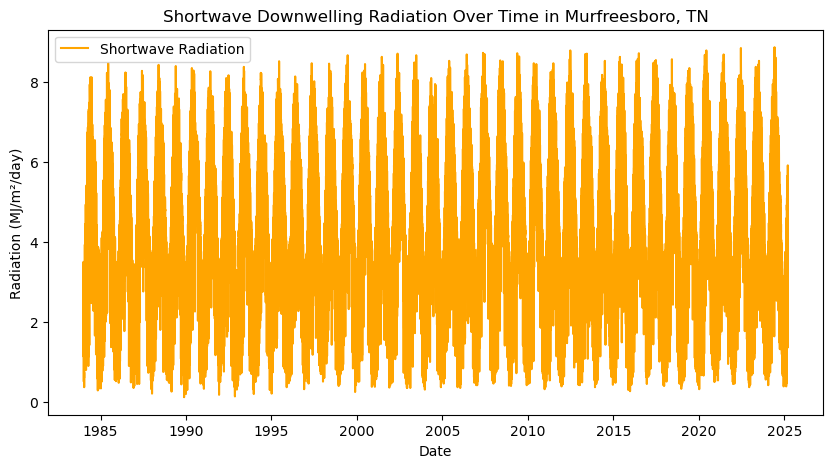

In [6]:
#Show graph of solar radiation over time
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df.index)

# Plot Shortwave Downwelling Radiation
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['ALLSKY_SFC_SW_DWN'], label="Shortwave Radiation", color='orange')
plt.xlabel("Date")
plt.ylabel("Radiation (MJ/m²/day)")
plt.title("Shortwave Downwelling Radiation Over Time in Murfreesboro, TN")
plt.legend()
plt.show()

In [7]:
df = df.reset_index()
df = df.drop('index', axis=1)
df

,T2M,ALLSKY_SFC_SW_DWN,PRECTOTCORR,date
0,-2.35,3.33,0.00,1984-01-01
1,-0.10,1.14,0.01,1984-01-02
2,-0.59,3.50,0.04,1984-01-03
3,1.47,1.65,0.70,1984-01-04
4,1.37,3.23,0.16,1984-01-05
...,...,...,...,...
15050,10.08,2.03,3.42,2025-03-16
15051,5.73,5.91,0.00,2025-03-17
15052,12.08,5.86,0.00,2025-03-18
15053,15.35,3.17,4.08,2025-03-19


In [8]:
#Find December 31, 2017 (this will be end of training set)
df[df['date'] == '2017-12-31']

,T2M,ALLSKY_SFC_SW_DWN,PRECTOTCORR,date
12418,-8.31,2.9,0.0,2017-12-31


The end of 2017 is on index 12418, so the training set will span indices 0 to 12418.

In [10]:
#Get next-day data
nextday = df[["ALLSKY_SFC_SW_DWN"]][1:]
nextday = nextday.reset_index(drop=True)
nextday = nextday.rename(columns={"ALLSKY_SFC_SW_DWN": "rad_nd"})
datam = pd.concat([df, nextday], axis=1)
datam = datam[:-1]

In [11]:
#Fit train and test data
xtrain = datam[["ALLSKY_SFC_SW_DWN"]][0:12419]
xtest = datam[["ALLSKY_SFC_SW_DWN"]][12419:]
ytrain = datam[["rad_nd"]][0:12419]
ytest = datam[["rad_nd"]][12419:]

In [12]:
#Scale data

from sklearn.preprocessing import MinMaxScaler

xscaler = MinMaxScaler(feature_range=(0, 1))
xtrain_scaled = xscaler.fit_transform(xtrain)
yscaler = MinMaxScaler(feature_range=(0, 1))
ytrain_scaled = yscaler.fit_transform(ytrain)
xtrain4lstm = xtrain_scaled.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest_scaled = xscaler.transform(xtest)
xtest4lstm = xtest_scaled.reshape((xtest.shape[0], 1, xtest.shape[1]))

In [13]:
#Fit LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(LSTM(10, input_shape=(1, xtrain.shape[1]),activation='relu'))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.fit(xtrain4lstm, ytrain_scaled, epochs=500, batch_size=100)

Epoch 1/500


/Users/harperkates/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 387us/step - loss: 0.1770  
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 0.0439
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 0.0397
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 0.0356
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 0.0336
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 0.0308
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 0.0322
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 0.0312
Epoch 9/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 0.0314
Epoch 10/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 0.0315
Epoch 11/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 0.0314
Epoch 12/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 0.0316
Epoch 13/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 0.0316
Epoch 14/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.0308
Epoch 15/500
125/125 ━━━━

In [14]:
#Forecast 2018-present data
ypred_scaled = model.predict(xtest4lstm)
ypred = yscaler.inverse_transform(ypred_scaled)
ytest['pred_lstm'] = ypred
ytest.head()

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step


,rad_nd,pred_lstm
12419,3.51,3.544883
12420,3.16,3.683016
12421,3.33,3.464806
12422,3.04,3.569753
12423,3.39,3.391912


In [15]:
#Add date variable to ytest (code generated by ChatGPT)

# Create date range
date_index = pd.date_range(start='2018-01-01', periods=len(ytest), freq='D')

# Assign as index
ytest.index = date_index

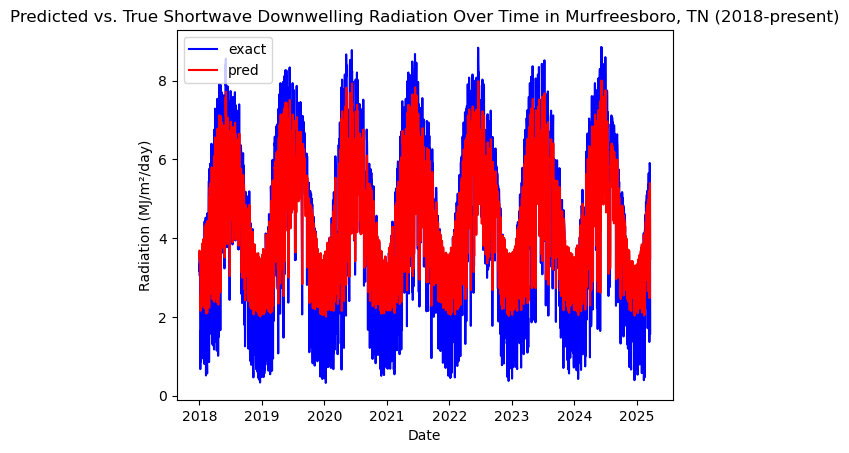

In [16]:
#Plot prediction vs. true data
plt.plot(ytest["rad_nd"],color = 'blue',label = 'exact')
plt.plot(ytest['pred_lstm'],color = 'red',label = 'pred')
plt.xlabel("Date")
plt.ylabel("Radiation (MJ/m²/day)")
plt.title("Predicted vs. True Shortwave Downwelling Radiation Over Time in Murfreesboro, TN (2018-present)")
plt.legend()
plt.show()

In [17]:
#Fit train and test data with precipitation as an additional variable
xtrain = datam[["ALLSKY_SFC_SW_DWN", "PRECTOTCORR"]][0:12419]
xtest = datam[["ALLSKY_SFC_SW_DWN", "PRECTOTCORR"]][12419:]
ytrain = datam[["rad_nd"]][0:12419]
ytest2 = datam[["rad_nd"]][12419:]

In [18]:
#Scale data
xscaler = MinMaxScaler(feature_range=(0, 1))
xtrain_scaled = xscaler.fit_transform(xtrain)
yscaler = MinMaxScaler(feature_range=(0, 1))
ytrain_scaled = yscaler.fit_transform(ytrain)
xtrain4lstm = xtrain_scaled.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest_scaled = xscaler.transform(xtest)
xtest4lstm = xtest_scaled.reshape((xtest.shape[0], 1, xtest.shape[1]))

In [19]:
#Fit LSTM model
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(LSTM(10, input_shape=(1, xtrain.shape[1]),activation='relu'))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.fit(xtrain4lstm, ytrain_scaled, epochs=500, batch_size=100)

Epoch 1/500


/Users/harperkates/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 0.1863 
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 0.0485
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 0.0350
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 0.0327
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 0.0313
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 0.0317
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 0.0311
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 0.0312
Epoch 9/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 0.0314
Epoch 10/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 0.0321
Epoch 11/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 0.0318
Epoch 12/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 0.0311
Epoch 13/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 0.0309
Epoch 14/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 0.0313
Epoch 15/500
125/125 ━━━━━

In [20]:
#Forecast 2018-present data
ypred_scaled = model.predict(xtest4lstm)
ypred = yscaler.inverse_transform(ypred_scaled)
ytest2['pred_lstm2'] = ypred
ytest2.head()

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,rad_nd,pred_lstm2
12419,3.51,2.969151
12420,3.16,3.154972
12421,3.33,2.915670
12422,3.04,2.987778
12423,3.39,2.866121


In [21]:
#Add date variable to ytest (code generated by ChatGPT)

# Create date range
date_index = pd.date_range(start='2018-01-01', periods=len(ytest), freq='D')

# Assign as index
ytest2.index = date_index

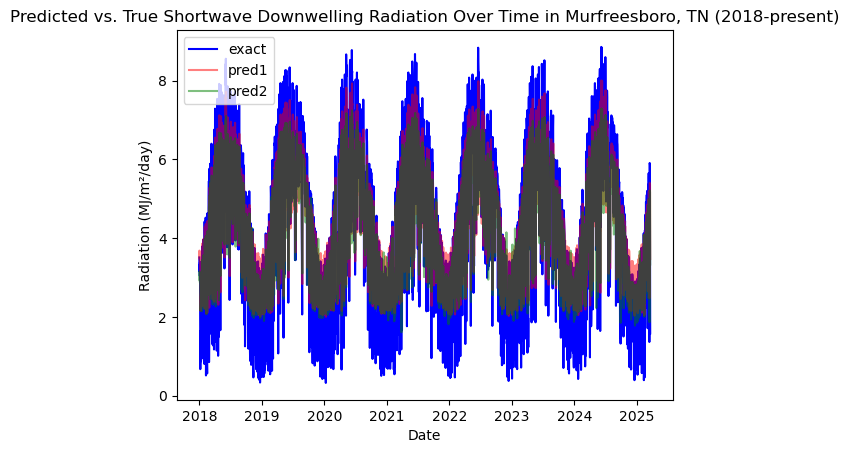

In [22]:
#Plot prediction vs. true data
plt.plot(ytest["rad_nd"],color = 'blue',label = 'exact')
plt.plot(ytest["pred_lstm"],color = 'red',label = 'pred1', alpha=0.5)
plt.plot(ytest2['pred_lstm2'],color = 'green',label = 'pred2', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Radiation (MJ/m²/day)")
plt.title("Predicted vs. True Shortwave Downwelling Radiation Over Time in Murfreesboro, TN (2018-present)")
plt.legend()
plt.show()

In [23]:
mse1 = sum((ytest['rad_nd']-ytest['pred_lstm'])**2)/len(ytest['rad_nd'])
mse2 = sum((ytest2['rad_nd']-ytest2['pred_lstm2'])**2)/len(ytest2['rad_nd'])

In [24]:
print(f"Univariate MSE: {mse1}")
print(f"Multivariate MSE: {mse2}")

Univariate MSE: 2.4081212559789944
Multivariate MSE: 2.303931920631687


In [84]:
df_copy = df.copy()

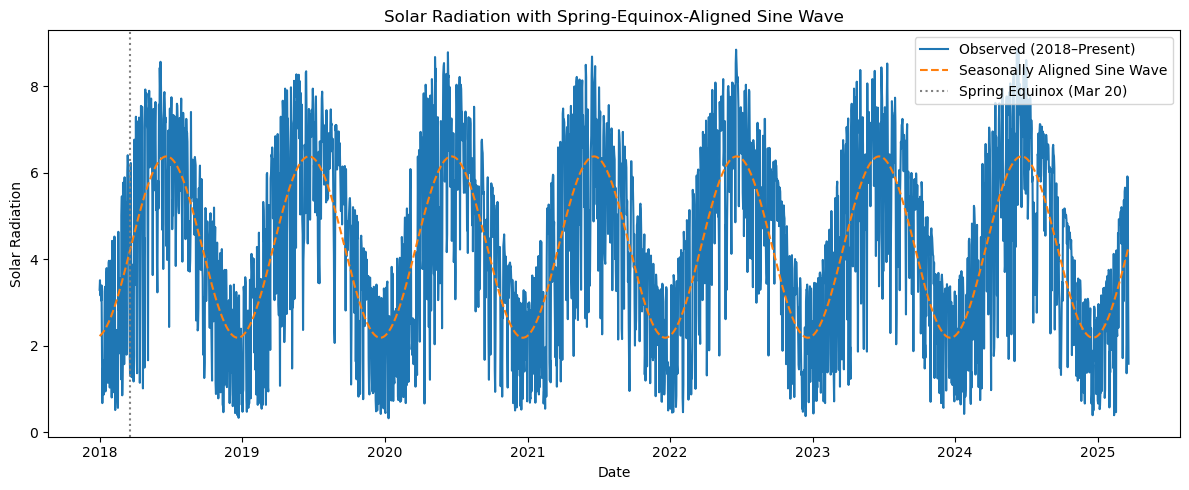

In [116]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Step 1: Filter your DataFrame
df_copy['date'] = pd.to_datetime(df_copy['date'])  # ensure datetime type
df_copy = df_copy.sort_values('date')  # ensure proper order

# Only use data from 2018 onwards for prediction
df_pred = df_copy[df_copy['date'] >= '2018-01-01'].copy()

# Step 2: Create continuous time variable from a fixed reference point
# You can use Jan 1, 2018 as t=0
reference_date = pd.to_datetime('2018-01-01')
df_copy['t'] = (df_copy['date'] - reference_date).dt.days / 365  # in years
df_pred['t'] = (df_pred['date'] - reference_date).dt.days / 365

# Step 3: Prepare variables
t_all = df_copy['t'].values
y_all = df_copy['ALLSKY_SFC_SW_DWN'].values

# Step 4: Define sine function
def sine_model(t, A, phi, C):
    f = 1  # 1 cycle per year
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Step 5: Fit model on full data or 2018+ data
A0 = (np.max(y_all) - np.min(y_all)) / 2
phi0 = 0
C0 = np.mean(y_all)

popt, _ = curve_fit(sine_model, t_all, y_all, p0=[A0, phi0, C0])
A_opt, phi_opt, C_opt = popt

# Step 8: Make predictions for 2018+
t_pred = df_pred['t'].values
y_pred_shifted = sine_model(t_pred, A_opt, phi_opt, C_opt)

# Step 8: Plot
plt.figure(figsize=(12, 5))
plt.plot(df_pred['date'], df_pred['ALLSKY_SFC_SW_DWN'], label='Observed (2018–Present)')
plt.plot(df_pred['date'], y_pred_shifted, label='Seasonally Aligned Sine Wave', linestyle='--')
plt.axvline(pd.to_datetime('2018-03-20'), color='gray', linestyle=':', label='Spring Equinox (Mar 20)')
plt.legend()
plt.title('Solar Radiation with Spring-Equinox-Aligned Sine Wave')
plt.xlabel('Date')
plt.ylabel('Solar Radiation')
plt.tight_layout()
plt.show()


In [134]:
#Calculate MSE of sine model
from sklearn.metrics import mean_squared_error

# y_true = actual values from 2018 onward
y_true = df_pred['ALLSKY_SFC_SW_DWN'].values

# y_pred = sine wave predictions aligned to spring equinox
y_pred = sine_model(df_pred['t'].values, A_opt, phi_shifted, C_opt)

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)
print(f"MSE: {mse:.2f}")

MSE: 5.36


In [136]:
#Forecast 2018-present data
ytest3 = datam[["ALLSKY_SFC_SW_DWN"]][12419:]
ytest3['pred_sine'] = ypred
ytest3.head()

,ALLSKY_SFC_SW_DWN,pred_sine
12419,3.29,2.969151
12420,3.51,3.154972
12421,3.16,2.915670
12422,3.33,2.987778
12423,3.04,2.866121


In [130]:
#Add date variable to ytest (code generated by ChatGPT)

# Create date range
date_index = pd.date_range(start='2018-01-01', periods=len(ytest), freq='D')

# Assign as index
ytest3.index = date_index

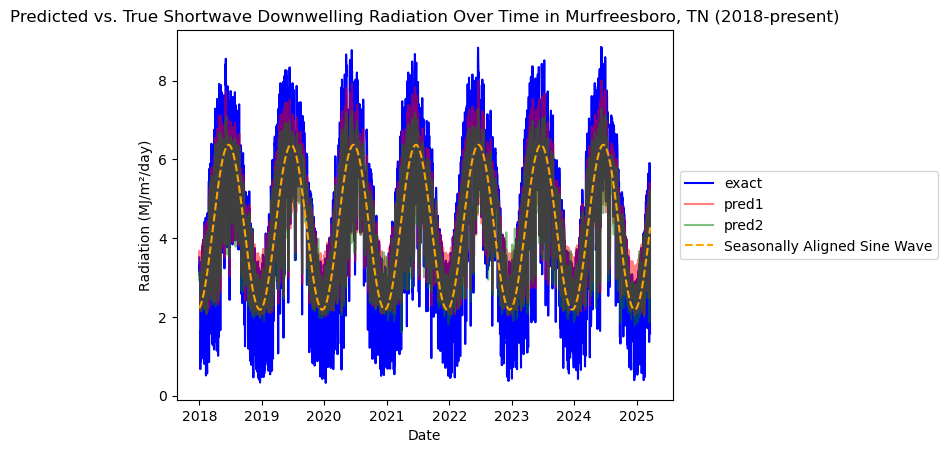

In [142]:
#Plot prediction vs. true data
plt.plot(ytest["rad_nd"],color = 'blue',label = 'exact')
plt.plot(ytest["pred_lstm"],color = 'red',label = 'pred1', alpha=0.5)
plt.plot(ytest2['pred_lstm2'],color = 'green',label = 'pred2', alpha=0.5)
plt.plot(df_pred['date'], y_pred_shifted, label='Seasonally Aligned Sine Wave', color="orange", linestyle='--')
plt.xlabel("Date")
plt.ylabel("Radiation (MJ/m²/day)")
plt.title("Predicted vs. True Shortwave Downwelling Radiation Over Time in Murfreesboro, TN (2018-present)")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [5]:
df.to_csv("power_data.csv")

In [10]:
df.to_csv("power_data_index.csv", index_label="date")